# Simple logistic regression

Examples are taken from Handbook of Biological Statistics](http://www.biostathandbook.com/simplelogistic.html) chapter on simple logistic regression.

In [15]:
import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import scipy.special
import seaborn as sns
import sklearn.linear_model
import statsmodels.api as sm
sns.set()

The lecture follows the `Spider` data from *Suzuki et al. (2006)*:

,Grain size (mm),Spiders
0,0.245,0
1,0.247,0
2,0.285,1
3,0.299,1
4,0.327,1


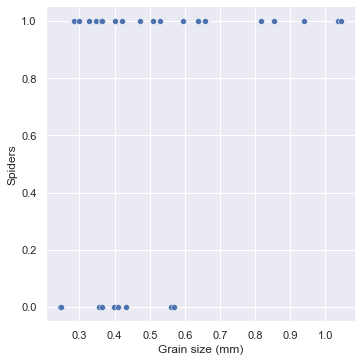

In [16]:
raw_data = """Grain size (mm)	Spiders
0.245	absent
0.247	absent
0.285	present
0.299	present
0.327	present
0.347	present
0.356	absent
0.36	present
0.363	absent
0.364	present
0.398	absent
0.4	present
0.409	absent
0.421	present
0.432	absent
0.473	present
0.509	present
0.529	present
0.561	absent
0.569	absent
0.594	present
0.638	present
0.656	present
0.816	present
0.853	present
0.938	present
1.036	present
1.045	present
"""
df = pd.read_table(io.StringIO(raw_data))
df.Spiders = (df.Spiders == 'present').astype(int)
sns.relplot('Grain size (mm)', 'Spiders', data=df)
df.head()

# Linear Probability Model

Applying linear regression directly to this leads to the **linear Probability Model**, where the probability of $y = 1$ is linear.

This can lead to some probabilities below 0 or above 1:

Optimization terminated successfully.
         Current function value: 0.546992
         Iterations 7


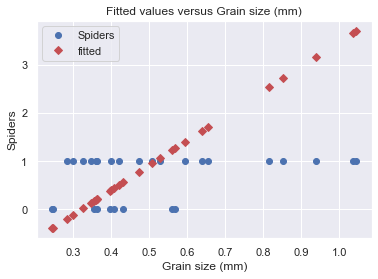

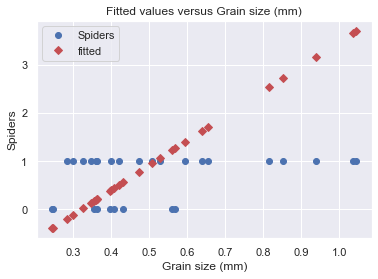

In [17]:
est = sm.Logit(df['Spiders'], sm.add_constant(df['Grain size (mm)'])).fit(cov_type='HC2')
est.summary()
sm.graphics.plot_fit(est, 'Grain size (mm)', vlines=False)

# Logistic Regression

More desirable would be a model that fits to the probability space exactly.

Specifically, we want the output to be a [cumulative distribution](https://en.wikipedia.org/wiki/Cumulative_distribution_function) so it looks like a [sigmoid curve](https://en.wikipedia.org/wiki/Sigmoid_function)

Similar to the **Probit Regression** we saw in lecture 3.5, **Logistic Regression** is a specialized model for when $y \in {0, 1}$, that is we have a binary target variable.

We have the odds $p$ that $y=1$ equal to 

$$log \dfrac{p}{1-p} = \beta \cdot X$$

The output is almost exactly the same shape as the CDF of the normal distribution in the Probit model, but is much easier to compute, so is used much more widely in practice, especially on huge datasets.

We can estimate the model using **Logistic Regression** in statsmodels:

In [18]:
y = df['Spiders']
X = sm.add_constant(df['Grain size (mm)'])

est = sm.Logit(y, X).fit(cov_type='HC2')
est.summary()
# sm.graphics.plot_fit(est, 'Grain size (mm)', vlines=False)

Optimization terminated successfully.
         Current function value: 0.546992
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Spiders   No. Observations:                   28
Model:                          Logit   Df Residuals:                       26
Method:                           MLE   Df Model:                            1
Date:                Sat, 16 Jan 2021   Pseudo R-squ.:                  0.1289
Time:                        16:11:57   Log-Likelihood:                -15.316
converged:                       True   LL-Null:                       -17.582
Covariance Type:                  HC2   LLR p-value:                   0.03324
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.6476      1.084     -1.520      0.128      -3.772       0.476
Grain size (mm)     5.1216      2.222      2.305      0.021       0.767       9.476
===================================================================================
"""

Here, coefficients are nonlinear so hard to interpret directly. However, you can always interpret the p-values, magnitude and sign of the coefficients normally.


# SKLearn version

For purely predictive models, scikit-learn has a logisitic regression classifier which uses regularization. To eliminate regularization, we set the regularization parameter `C` very high.

In [19]:
# C=1e12 is effectively no regularization - see https://github.com/scikit-learn/scikit-learn/issues/6738
clf = sklearn.linear_model.LogisticRegression(C=1e8, random_state=0)
clf.fit(df[['Grain size (mm)']], df['Spiders'])
print("Coeddificents: ", clf.intercept_, clf.coef_)

Coeddificents:  [-1.64761944] [[5.12153671]]


To retrieve the original probabilities, we inverse the `log` in the logit equation by exponentiating it:
$$
Pr(spider) = \frac{e^{-1.6476+5.1215(grain \; size)}}{1+e^{-1.6476+5.1215(grain \; size)}}
$$

In [20]:
def plot_log_reg(x, y, data, clf, xmin=None, xmax=None, alpha=1, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.scatter(data[x], data[y], color='black', zorder=20, alpha=alpha)
    if xmin is None:
        xmin = x.min()
    if xmax is None:
        xmax = x.max()
    X_test = np.linspace(xmin, xmax, 300)

    loss = scipy.special.expit(X_test * clf.coef_ + clf.intercept_).ravel()
    ax.plot(X_test, loss, linewidth=3)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    fig.tight_layout()
    sns.despine()
    return fig, ax

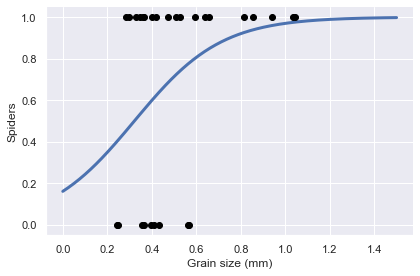

In [21]:
plot_log_reg(x='Grain size (mm)', y='Spiders', data=df, clf=clf, xmin=0, xmax=1.5);

# Predictive modelling

It's common in predictive modelling to split your dataset in "train" and "test" sets, to make sure you don't overfit.

Note the difference between sklearn and statsmodels: sklearn outputs the actual predicted class, while statsmodels outputs the predicted probability when predicting. You can always get the probability in sklearn with `predict_proba()`.

Let's do a round of this on the **Titanic Dataset**.

In [53]:
df = sns.load_dataset('titanic')
df['class'] = df['class'].astype(str)
df['deck'] = df['deck'].astype(str)

num_cols = ['age', 'fare']
cat_cols = ['sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alone']

df = df.dropna(axis=0, subset=num_cols)

y = df.survived
X = df[['age', 'fare']].copy()
X['age2'] = X.age ** 2
X['fare2'] = X.fare ** 2
for c in cat_cols:
    X = X.join(pd.get_dummies(df[c], drop_first=True, prefix=c))

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [55]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.78


# Interpretation of Prediction

1. **Confusion Matrix** is a matrix of true/false positive/negative predictions. You want more entries on the main diagonal, and fewer off the main diagonal.

In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[110  15]
 [ 32  58]]


2. The **precision** is the ratio `tp / (tp + fp)` where tp is the number of true positives and fp the number of false positives. 

The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

3. The **recall** is the ratio `tp / (tp + fn)` where tp is the number of true positives and fn the number of false negatives. 

The recall is intuitively the ability of the classifier to find all the positive samples.

4. The **F-beta** score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

5. The **support** is the number of occurrences of each class in `y_true`.


In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

           0       0.77      0.88      0.82       125
           1       0.79      0.64      0.71        90

    accuracy                           0.78       215
   macro avg       0.78      0.76      0.77       215
weighted avg       0.78      0.78      0.78       215



# ROC Curve

The [ROC Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) plots the True and False positive rate across the test dataset. You want more AUC above the redline (which is effectively a random prediction)

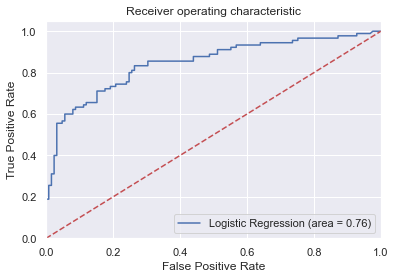

In [52]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()